[View in Colaboratory](https://colab.research.google.com/github/Masum06/gender_newspaper/blob/master/char_rnn_newspaper.ipynb)

###Connect to drive, save the model

In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [5]:
!cp drive/data/* ./

cp: -r not specified; omitting directory 'drive/data/newspaper_text'


In [6]:
ls -l drive/data/

total 953943
-rw-r--r-- 1 root root      1954 Aug  6 13:04 cse13_names.txt
-rw-r--r-- 1 root root 259526518 Jul 29 10:29 hsc_name_gender.csv
-rw-r--r-- 1 root root  58668225 Aug  6 15:36 hsc_unique.csv
-rw-r--r-- 1 root root     27174 Aug  6 08:48 news_db_instance.json
-rw-r--r-- 1 root root 658608032 Aug  6 08:49 news_db.json
drwxr-xr-x 2 root root      4096 Aug  6 15:33 newspaper_text/


In [7]:
ls -l

total 953960
-rw-r--r-- 1 root root      1954 Aug  7 04:57 cse13_names.txt
drwxr-xr-x 1 root root      4096 Aug  7 04:56 datalab/
drwxr-xr-x 2 root root      4096 Aug  7 04:56 drive/
-rw-r--r-- 1 root root 259526518 Aug  7 04:57 hsc_name_gender.csv
-rw-r--r-- 1 root root  58668225 Aug  7 04:57 hsc_unique.csv
-rw-r--r-- 1 root root     27174 Aug  7 04:58 news_db_instance.json
-rw-r--r-- 1 root root 658608032 Aug  7 04:58 news_db.json


###Down From Mega

In [4]:
%%bash
git clone https://github.com/jeroenmeulenaar/python3-mega.git python3mega
cd python3mega
pip install -r requirements.txt

  Running setup.py bdist_wheel for URLObject: started
  Running setup.py bdist_wheel for URLObject: finished with status 'done'
  Stored in directory: /content/.cache/pip/wheels/fd/7e/18/ccb55ecc2834f945b769c1ff1df12ca5a14400ccfc58e3c515
  Running setup.py bdist_wheel for pycrypto: started
  Running setup.py bdist_wheel for pycrypto: finished with status 'done'
  Stored in directory: /content/.cache/pip/wheels/27/02/5e/77a69d0c16bb63c6ed32f5386f33a2809c94bd5414a2f6c196
Successfully built URLObject pycrypto


Cloning into 'python3mega'...


In [0]:
import os
os.chdir('python3mega')
from mega import Mega
m = Mega.from_ephemeral()
os.chdir('..')

In [0]:
m.download_from_url('https://mega.nz/#!NI4HwbBZ!tmDw05UD1Iro-upNHXr5hLdj-VgbFWEMJW3zO9iB0cE') # HSC Unique Name dataset

In [147]:
!ls

bothReplaced.txt     hsc_unique		    nonGender.txt
datalab		     hsc_unique.csv	    python3mega
drive		     maleReplaced.txt	    uniqueNames.txt
femaleReplaced.txt   news_db_instance.json  weights-improvement-01-0.9763.hdf5
hsc_name_gender.csv  news_db.json	    weights-improvement-02-0.9767.hdf5


### Character RNN

In [0]:
# https://keras.io/
# ignore in colab
!pip install -q keras
!pip install scikit-learn
!pip install matplotlib

In [9]:
%matplotlib inline
import itertools
import keras
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional
from keras.layers import LSTM, GRU
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

fileName = './hsc_unique.csv'

# Lowering the texts and replacing with numeral value
df = pd.read_csv(fileName, encoding='utf-8')
df.columns = ['name', 'gender']
df['name'] = df['name'].str.lower()

df = df.dropna()
#df = df.drop_duplicates()

# Getting all available strings to find out the characters used
all_string = " ".join([name for name in df['name']])
unique_characters = list(set(list(all_string)))

# Mapping between character to index and index to character
char2idx = { c : i for i, c in enumerate(unique_characters) }
idx2char = {c: k for k, c in char2idx.items()}

In [0]:
# Converts a name into vector
def name2vector(name):
    chars = list(name)
    vector = [ char2idx[c] for c in chars ]
    return np.array(vector)

# Converts names to fixed size tensor
def names2tensor(names, maxlen=25):
    namelist = [name2vector(name) for name in names]
    return sequence.pad_sequences(np.array(namelist), maxlen=maxlen)  # root of all troubles

def vector2name(vector):
  name = ""
  for id in vector:
    name+=idx2char[id]
  return name

def tensor2name(tensor):
  namelist = [vector2name(vector) for vector in tensor]
  return namelist

Preparing dataset

In [0]:
# train dataset
X = np.array(names2tensor(df['name'], maxlen=25)) #
Y = np.array([int(g) for g in df['gender']])

X, Y = shuffle(X, Y, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3) #changed

### Building Model

Setting up parameters

In [0]:
# max features
max_features = 20000
batch_size = 32
epochs = 1

In [32]:
# Model building and training
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5)) #changed
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']             
             )

Build model...


Autosaving models parameters

In [0]:
filepath="weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


### Train

In [34]:
print('Train...')
history = model.fit(x_train, y_train,batch_size=batch_size, epochs=2, callbacks=callbacks_list, validation_data=(x_test, y_test))

Train...
Train on 2121126 samples, validate on 909055 samples
Epoch 1/2
  19488/2121126 [..............................] - ETA: 1:30:01 - loss: 0.4520 - acc: 0.7779

1836544/2121126 [========================>.....] - ETA: 11:37 - loss: 0.1189 - acc: 0.9561

Buffered data was truncated after reaching the output size limit.

In [1]:
model

NameError: ignored

In [0]:
!mv weights-improvement* drive/deeper/data/char_rnn_hsc_models/

# Saving Loading

### Save Model and Weights

In [0]:
i = 4

model.save('char_rnn_hsc_model_big_data_1.h5')

In [0]:
!cp char_rnn_hsc_model_big_data_1.h5 drive/deeper/data/char_rnn_hsc_models/
!cp char_rnn_hsc_model_big_data_weights_1.h5 drive/deeper/data/char_rnn_hsc_models/

In [0]:
model.load_weights('drive/deeper/data/char_rnn_hsc_models/char_rnn_hsc_model_big_data_weights_1.h5')

In [0]:
ls

char_rnn_hsc_model_3.h5  datalab/  drive/  hsc_name_gender.csv  python3mega/


Highest accuracy 97.67%



###Load model and run

In [0]:
!cp drive/deeper/data/char_rnn_hsc_models/char_rnn_hsc_model_3.h5 ./

In [0]:
model.load_weights('char_rnn_hsc_model_3.h5')

In [0]:
# LOAD SAVED MODEL
from keras.models import load_model

#del model  # deletes the existing model
model = load_model('char_rnn_hsc_model_3.h5')

### Save Model using Pickle

In [0]:
!pip install keras-pickle-wrapper

In [0]:
import pickle
from keras_pickle_wrapper import KerasPickleWrapper

#### Save Pickle

In [0]:
modelWrapper = KerasPickleWrapper(model)

In [0]:
with open(r"model.pickle", "wb") as output_file:
  pickle.dump(modelWrapper, output_file)

In [22]:
ls

cse13_names.txt  drive/               hsc_unique.csv  news_db_instance.json
datalab/         hsc_name_gender.csv  model.pickle    news_db.json


In [0]:
!cp model.pickle drive/deeper/data/char_rnn_hsc_models/

#### Load Pickle

In [0]:
!cp drive/deeper/data/char_rnn_hsc_models/model.pickle ./

In [0]:
with open(r"model.pickle", "rb") as input_file:
  model = pickle.load(input_file)()

In [27]:
model

### Confusion Matrix

In [0]:
y_pred = np.array([y[0] for y in model.predict_classes(x_test)])

Normalized confusion matrix
[[0.97453167 0.02546833]
 [0.02165181 0.97834819]]


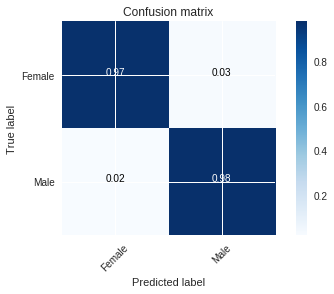

In [121]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['Female', 'Male'], normalize=True)

### Check Mismatched Names

In [0]:
x_test_names = tensor2name(x_test)

In [0]:
test_indexes = np.arange(len(x_test))

In [87]:
mismatch_indexes = test_indexes[y_pred != y_test]
print(mismatch_indexes)

[    16     43     56 ... 909005 909016 909045]


In [88]:
len(mismatch_indexes)/len(x_test)

0.023268119090704083

In [0]:
incorrect_males = {}
incorrect_females = {}
for i in mismatch_indexes:
  if y_pred[i] == 0:
    temp = {}
    temp["name"] = x_test_names[i]
    temp["test"] = y_test[i]
    temp["pred"] = y_pred[i]
    incorrect_males[i] = temp
  else:
    temp = {}
    temp["name"] = x_test_names[i]
    temp["test"] = y_test[i]
    temp["pred"] = y_pred[i]
    incorrect_females[i] = temp

In [145]:
incorrect_males

{73: {'name': '----------mst. soma akter', 'pred': 0, 'test': 1},
 187: {'name': '-------------manky sharen', 'pred': 0, 'test': 1},
 240: {'name': '--------------------paple', 'pred': 0, 'test': 1},
 351: {'name': '---most. mosharof hossain', 'pred': 0, 'test': 1},
 454: {'name': '-----------------salemusa', 'pred': 0, 'test': 1},
 552: {'name': '-------------al mohayminu', 'pred': 0, 'test': 1},
 560: {'name': '----------------meghu roy', 'pred': 0, 'test': 1},
 816: {'name': '-------------jyasta barua', 'pred': 0, 'test': 1},
 825: {'name': '------------promite barua', 'pred': 0, 'test': 1},
 1225: {'name': '-------------swecha marma', 'pred': 0, 'test': 1},
 1298: {'name': '---mowlana harunur rashid', 'pred': 0, 'test': 1},
 1366: {'name': '-------------pobitra malo', 'pred': 0, 'test': 1},
 1390: {'name': '---------mehlaching marma', 'pred': 0, 'test': 1},
 1394: {'name': '--------------anam akhter', 'pred': 0, 'test': 1},
 1444: {'name': '---------------mirchi ali', 'pred': 0, 't

In [95]:
incorrect_females

{16: {'name': '----------------elu barua', 'pred': 1, 'test': 0},
 43: {'name': '-------------kanan mondol', 'pred': 1, 'test': 0},
 56: {'name': '----------mohammad ismail', 'pred': 1, 'test': 0},
 117: {'name': '------------------any sen', 'pred': 1, 'test': 0},
 129: {'name': '--------md. foridul islam', 'pred': 1, 'test': 0},
 157: {'name': '-------------shewle wahid', 'pred': 1, 'test': 0},
 224: {'name': 'anno    jaman   boishakhi', 'pred': 1, 'test': 0},
 228: {'name': '----------ehtemanur ahmed', 'pred': 1, 'test': 0},
 241: {'name': '--------------tayemer nur', 'pred': 1, 'test': 0},
 274: {'name': '----------shamshur nashar', 'pred': 1, 'test': 0},
 332: {'name': '-----------------shorchan', 'pred': 1, 'test': 0},
 354: {'name': '------------------golazan', 'pred': 1, 'test': 0},
 377: {'name': '-----------bakul baishnob', 'pred': 1, 'test': 0},
 500: {'name': '-rubayeth  marzan   rimi.', 'pred': 1, 'test': 0},
 530: {'name': '--krishna ghosh chowdhury', 'pred': 1, 'test': 0}

In [97]:
print(len(incorrect_males), len(incorrect_females))

11347 9805


# Bring the newspaper notebook here

In [42]:
ls

datalab/             news_db_instance.json  weights-improvement-01-0.9763.hdf5
drive/               news_db.json           weights-improvement-02-0.9767.hdf5
hsc_name_gender.csv  python3mega/


In [43]:
pwd

'/content'

In [0]:
m.download_from_url('https://mega.nz/#!5VZTGC4Y!zYlnGkVKoEOVaNqm2UwCSWDZXE_g9u4E3JcYj0ipE8Q') #news_db_instance.json

In [0]:
m.download_from_url('https://mega.nz/#!sBIyzQJK!blCZdV-tca0uJ0yR4l08DEcFoMGuQ3PuNDLbTaD_NqY') #news_db.json

In [0]:
import numpy as np
from keras.preprocessing import sequence

del char2idx
del idx2char

char2idx = {'o': 0, 'b': 1, 'e': 2, 'w': 3, 'p': 4, '-': 5, 't': 6, 'k': 7, 'q': 8, 'f': 9, 'n': 10, 'z': 11, 'u': 12, ' ': 13, '.': 14, 'd': 15, 'h': 16, 'm': 17, '(': 18, 'r': 19, ')': 20, 'j': 21, 'l': 22, 'i': 23, 's': 24, 'c': 25, 'a': 26, 'g': 27, ':': 28, 'v': 29, 'y': 30, 'x': 31}
idx2char = {0: 'o', 1: 'b', 2: 'e', 3: 'w', 4: 'p', 5: '-', 6: 't', 7: 'k', 8: 'q', 9: 'f', 10: 'n', 11: 'z', 12: 'u', 13: ' ', 14: '.', 15: 'd', 16: 'h', 17: 'm', 18: '(', 19: 'r', 20: ')', 21: 'j', 22: 'l', 23: 'i', 24: 's', 25: 'c', 26: 'a', 27: 'g', 28: ':', 29: 'v', 30: 'y', 31: 'x'}

# Converts a name into vector
def name2vectorTest(name):
    name = name.lower()
    new_name = ""
    for char in name:
      if char in char2idx:
        new_name += char
    chars = list(new_name)
    vector = [ char2idx[c] for c in chars ]
    return np.array(vector)

# Converts names to fixed size tensor
def names2tensorTest(names, maxlen=25):
    namelist = [name2vectorTest(name) for name in names]
    return sequence.pad_sequences(np.array(namelist), maxlen=maxlen)  # root of all troubles

def nameTest(name):
  result = model.predict_classes(np.array(names2tensorTest([name.lower()])))[0][0]
  if result:
    print("Male")
  else:
    print("Female")

def returnGender(name):
  result = model.predict_classes(np.array(names2tensorTest([name.lower()])))[0][0]
  if result:
    return "Male"
  else:
    return "Female"
  
def isMale(name):
  result = model.predict_classes(np.array(names2tensorTest([name.lower()])))[0][0]
  return result

def genderDictionary(ner_person):
  dictionary = {}
  for name in ner_person:
    dictionary[name] = isMale(name)
  return dictionary

def concatAll(content, ner_person):
  ner_person = sorted(ner_person, key=len, reverse=True)
  for name in ner_person:
    content = content.replace(name, name.replace(" ", ""))
  return content
  
def replaceMaleConcatFemale(content, genderDict):
  ner_person = sorted(genderDict, key=len, reverse=True)
  
  for name in ner_person:
    if genderDict[name] == 0:
      content = content.replace(name, name.replace(" ", ""))
    else:
      content = content.replace(name, "man")
  return content

def replaceFemaleConcatMale(content, genderDict):
  ner_person = sorted(genderDict, key=len, reverse=True)
  
  for name in ner_person:
    if genderDict[name] == 1:
      content = content.replace(name, name.replace(" ", ""))
    else:
      content = content.replace(name, "woman")
  return content

def replaceAll(content, genderDict):
  ner_person = sorted(genderDict, key=len, reverse=True)
  
  for name in ner_person:
    if genderDict[name] == 1:
      content = content.replace(name, "man")
    else:
      content = content.replace(name, "woman")
  return content

In [0]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def diff(t_a, t_b, c):
    t_diff = relativedelta(t_b, t_a)*c  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

In [131]:
isMale("shaikh hasina")

1

In [0]:
import sys
import json

input_text_none = ""
input_text_man = ""
input_text_woman = ""
input_text_both = ""
all_name_set = set()

i = 1
data = "news_db_instance.json"
file_len = 165236
t_a = datetime.now()

with open(data, encoding="utf-8") as file:
  for line in file:
    try:
      i+=1
      parsed_json = json.loads(line)
      
      section = parsed_json["section"]
      if section == "World" or section == "Sports":
        continue
        
      content = parsed_json["content"]
      content += " "
      ner_unique_person = parsed_json["ner_unique_person"]
      all_name_set.update(ner_unique_person)
      genderDict = genderDictionary(ner_unique_person)
      
      input_text_none += concatAll(content, ner_unique_person)
      input_text_man  += replaceMaleConcatFemale(content, genderDict)
      input_text_woman += replaceFemaleConcatMale(content, genderDict)
      input_text_both += replaceAll(content, genderDict)
      
      # PRINT STATUS (print is an expensive function call)
      if i%100==0:
        t_b = datetime.now()
        t_past = diff(t_a, t_b, 1)
        t_remain = diff(t_a, t_b, (file_len-i)/(i+0.000001))
        print( "\r{:.2f}% finished.".format(100*i/(file_len-1)), "\tCurrent Position:", i, 
          "\tTime Elapsed:",t_past, "\tEstimated Remaining Time:",t_remain, end="")

    except Exception as e:
      print("\nException: ", e,"\nSys info: ", sys.exc_info()[0])
      continue
    
file.close()

In [106]:
print(len(input_text_none.split(" ")))
print(len(input_text_man.split(" ")))
print(len(input_text_woman.split(" ")))
print(len(input_text_both.split(" ")))
print(len(all_name_set))

3182
3182
3182
3182
26


In [107]:
print("normal: ", input_text_none[0:50])
print("Male name replaced: ", input_text_man[0:50])
print("Female name replaced: ", input_text_woman[0:50])
print("Both name replaced: ", input_text_both[0:10])
print("Unique names: ", list(all_name_set)[0:4])

normal:  From guiding you on using the right equipment in g
Male name replaced:  From guiding you on using the right equipment in g
Female name replaced:  From guiding you on using the right equipment in g
Both name replaced:  From guidi
Unique names:  ['Bangla Bhai', 'Ayub Quadri', 'Nasir', 'Muhammad Yunus']


In [0]:
nonGender = open("nonGender.txt", "w")
maleReplaced = open("maleReplaced.txt", "w")
femaleReplaced = open("femaleReplaced.txt", "w")
bothReplaced = open("bothReplaced.txt", "w")
uniqueNames = open("uniqueNames.txt", "w")

In [0]:
nonGender.write(input_text_none)
maleReplaced.write(input_text_man)
femaleReplaced.write(input_text_woman)
bothReplaced.write(input_text_both)

nonGender.close()
maleReplaced.close()
femaleReplaced.close()
bothReplaced.close()

In [0]:
for item in all_name_set:
  item_gender = returnGender(item)
  uniqueNames.write("{}\t-\t{}\n".format(item, item_gender))
  
uniqueNames.close()

In [0]:
%%bash
mkdir -p drive/data/newspaper_text/

cp nonGender.txt drive/data/newspaper_text/
cp maleReplaced.txt drive/data/newspaper_text/
cp femaleReplaced.txt drive/data/newspaper_text/
cp bothReplaced.txt drive/data/newspaper_text/
cp uniqueNames.txt drive/data/newspaper_text/

In [113]:
nameTest("Khaleda Zia")

Male
